In [1]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import fiona

# Potentiel solaire package
from potentiel_solaire.constants import DATA_FOLDER

In [2]:
# Executer ci dessous ci besoin pour récupérer les données
# !extract-sample-data
# Et pour sauver une version markdown des notebooks, utiliser
# jupyter nbconvert verif_haut_niveau.ipynb --to markdown --output-dir=exports/

In [23]:
src = DATA_FOLDER / "saint_denis_reference_data.gpkg"
layers = fiona.listlayers(src)

for layer in layers:
    gdf_sd = gpd.read_file(src, layer=layer)
    print(f"* Couche: {layer} avec {len(gdf_sd)} éléments.")

* Couche: annuaire_education avec 88 éléments.
* Couche: annuaire_education_sans_zone avec 24 éléments.
* Couche: bdtopo_education avec 49 éléments.
* Couche: bdtopo_batiment avec 437 éléments.
* Couche: cadastre_parcellaire avec 477 éléments.
* Couche: potentielsolaire_bati avec 496 éléments.
* Couche: potentielsolaire_toitures avec 357 éléments.
* Couche: perimetre_st_denis avec 1 éléments.
* Couche: identifiers avec 88 éléments.


In [24]:
zones = gpd.read_file(src, layer="bdtopo_education")
pci = gpd.read_file(src, layer="cadastre_parcellaire")
ecoles = gpd.read_file(src, layer="annuaire_education")
ecoles_seules = gpd.read_file(src, layer="annuaire_education_sans_zone") 
potentiel = gpd.read_file(src, layer="potentielsolaire_toitures")
batiments_ecoles = gpd.read_file(src, layer="bdtopo_batiment")
stdenis = gpd.read_file(src, layer="perimetre_st_denis")

/tmp/ipykernel_361433/2750821678.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()


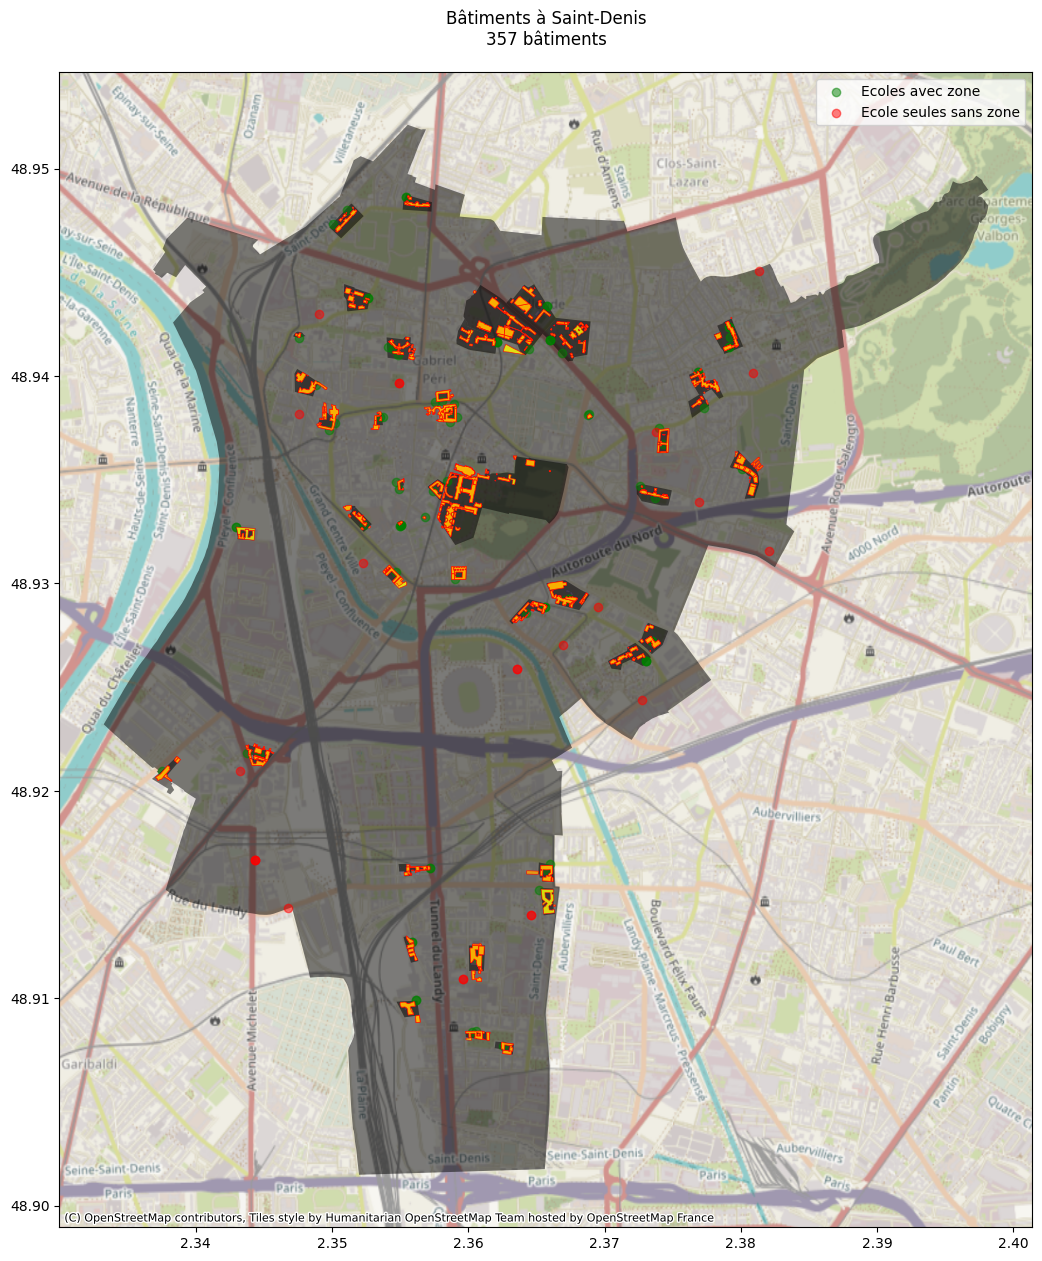

In [25]:
fig1, ax1 = plt.subplots(figsize=(15, 15))
zones.plot(ax=ax1, color='black', alpha=0.5, label='Zones')
stdenis.plot(ax=ax1, color='black', alpha=0.5, label='Zones')
ecoles.plot(ax=ax1, color='green', alpha=0.5, label='Ecoles avec zone')
ecoles_seules.plot(ax=ax1, color='red', alpha=0.5, label='Ecole seules sans zone')
pci.plot(ax=ax1, facecolor='pink', edgecolor='blue', linewidth=0.5, alpha=0.1, label='Saint-Denis')
batiments_ecoles.plot(ax=ax1, facecolor='yellow', edgecolor='red', linewidth=0.5, alpha=0.8, label='Saint-Denis')
potentiel.plot(ax=ax1, facecolor='orange', edgecolor='red', linewidth=0.5, alpha=0.8, label='Saint-Denis')
cx.add_basemap(ax1, crs=zones.crs, zoom=14)
ax1.set_title(f"Bâtiments à Saint-Denis\n{len(potentiel)} bâtiments", pad=20)
ax1.legend()
plt.show()

# Premiere estimation

France: 1000 kWh/m2/an  à 1900 kWh/m2/an

In [28]:
pci[["cleabs_left"]]

,cleabs_left
0,SURFACTI0000000002555814
1,SURFACTI0000000002555651
2,SURFACTI0000000002555651
3,SURFACTI0000000002555814
4,SURFACTI0000000002555599
...,...
472,SURFACTI0000000002555554
473,SURFACTI0000000315148819
474,SURFACTI0000000245007044
475,SURFACTI0000002008347531


In [27]:
pci.columns

Index(['TYPE', 'index_right__cadastre', 'cleabs', 'code_insee__cadastre',
       'code_insee_de_l_arrondissement__cadastre',
       'code_insee_de_la_collectivite_terr__cadastre',
       'code_insee_du_departement__cadastre',
       'code_insee_de_la_region__cadastre', 'population__cadastre',
       'surface_en_ha__cadastre', 'date_creation', 'date_modification',
       'date_d_apparition', 'date_de_confirmation', 'code_postal__cadastre',
       'nom_officiel__cadastre', 'chef_lieu_d_arrondissement__cadastre',
       'chef_lieu_de_collectivite_terr__cadastre',
       'chef_lieu_de_departement__cadastre', 'chef_lieu_de_region__cadastre',
       'capitale_d_etat__cadastre', 'date_du_recensement__cadastre',
       'organisme_recenseur__cadastre', 'codes_siren_des_epci__cadastre',
       'lien_vers_chef_lieu__cadastre',
       'liens_vers_autorite_administrative__cadastre', 'code_siren__cadastre',
       'index__zone', 'cleabs_left', 'categorie', 'nature', 'nature_detaillee',
       'topon

In [6]:
gdf = potentiel

gdb = batiments_ecoles

In [37]:
batiments_calcules = gdf[list(gdf.columns)[:18]+["geometry"]]
batiments_calcules = batiments_calcules.rename(columns={"id": "cleabs"})
batiments_reference = gdb[['cleabs_left__bat',
 'nature__bat',
 'usage_1',
 'usage_2',
 'nombre_d_etages',
 'materiaux_des_murs',
 'materiaux_de_la_toiture',
 'hauteur',"geometry"]]
batiments_reference = batiments_reference.rename(columns={"cleabs_left__bat": "cleabs"})
communs = list(set(batiments_calcules.cleabs) & set(batiments_reference.cleabs))
batiments_reference = batiments_reference[batiments_reference.cleabs.isin(communs)]
batiments_calcules = batiments_calcules[batiments_calcules.cleabs.isin(communs)]


# On calcule les surfaces
batiments_calcules = batiments_calcules.to_crs(epsg=6933)
batiments_calcules["surface_calculee"] = batiments_calcules.area
batiments_calcules = batiments_calcules.to_crs(epsg=4326)

batiments_reference = batiments_reference.to_crs(epsg=6933)
batiments_reference["surface_calculee"] = batiments_reference.area
batiments_reference = batiments_reference.to_crs(epsg=4326)

In [38]:
batiments_calcules["calcul_naif"] = 1100*batiments_calcules["surface_calculee"]

In [40]:
batiments_calcules = batiments_calcules[["surface_calculee", "surf_util", "production", "calcul_naif","moyenne2", "indic2","forme",  "gisement"	,"eq_pano",	"eq_surf"	,"cleabs", "geometry"]]
test = batiments_calcules[batiments_calcules.surf_util > 0]
test["ratio"] = test["production"] / test["calcul_naif"]
ratio = test["ratio"].mean()
batiments_calcules["calcul_naif"] = 1100*batiments_calcules["surface_calculee"]
batiments_calcules["calcul_naif_maj"] = 1100*batiments_calcules["surface_calculee"]*ratio
batiments_calcules["ratio_surface"] = batiments_calcules["surf_util"]/batiments_calcules["surface_calculee"]
batiments_calcules

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,surface_calculee,surf_util,production,calcul_naif,moyenne2,indic2,forme,gisement,eq_pano,eq_surf,cleabs,geometry,calcul_naif_maj,ratio_surface
0,3182.864620,1944.00,213541.062838,3.501151e+06,1205.511696,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000318256828,"POLYGON ((2.36719 48.93004, 2.36696 48.93002, ...",153562.836115,0.610771
1,4253.467615,810.00,90874.379954,4.678814e+06,1231.240041,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000243404073,"POLYGON ((2.36013 48.91242, 2.36015 48.91213, ...",205215.938582,0.190433
2,128.561045,2.25,0.000000,1.414171e+05,NaN,-1,Npans,Non favorable,Non favorable,Non favorable,BATIMENT0000000229477227,"POLYGON ((2.35275 48.94371, 2.35246 48.94377, ...",6202.651070,0.017501
3,3146.850632,936.00,104887.667195,3.461536e+06,1229.801070,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000002629660,"POLYGON ((2.34956 48.93933, 2.34964 48.93942, ...",151825.278652,0.297440
4,552.109173,162.00,22486.547854,6.073201e+05,1134.034730,3,toit2pentes,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000229478106,"POLYGON ((2.38134 48.93547, 2.38129 48.93551, ...",26637.466764,0.293420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,20.386765,6.75,1016.122389,2.242544e+04,1229.874593,1,petit_toit,faible,2 à 9 panneaux,entre 4.5 et 20 m2,BATIMENT0000000243407957,"POLYGON ((2.36258 48.9433, 2.36253 48.94327, 2...",983.594895,0.331097
350,31.507794,6.75,959.893115,3.465857e+04,1161.816890,1,petit_toit,faible,2 à 9 panneaux,entre 4.5 et 20 m2,BATIMENT0000000243408047,"POLYGON ((2.36454 48.94175, 2.36454 48.94174, ...",1520.148276,0.214233
351,21.832447,0.00,0.000000,2.401569e+04,NaN,-1,petit_toit,Non favorable,Non favorable,Non favorable,BATIMENT0000000243404353,"POLYGON ((2.37179 48.92651, 2.37176 48.9265, 2...",1053.344335,0.000000
355,782.855874,483.75,52563.953253,8.611415e+05,1192.486116,3,plat,important,plus de 50 panneaux,plus de 115 m2,BATIMENT0000000353683846,"POLYGON ((2.36253 48.90733, 2.36314 48.90729, ...",37770.242428,0.617930


<Axes: title={'center': 'Relation between production et surface calculée\nloglog scale'}, xlabel='surface_calculee', ylabel='production'>

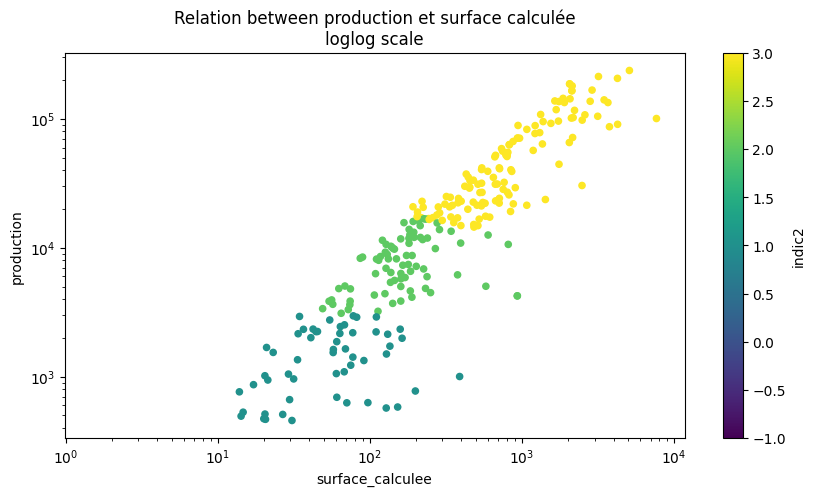

In [10]:
batiments_calcules.plot.scatter(x="surface_calculee",y="production",c="indic2",colormap='viridis',\
    title='Relation between production et surface calculée\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))

<Axes: title={'center': 'Relation between surface calculée et surface utile\nloglog scale'}, xlabel='surface_calculee', ylabel='surf_util'>

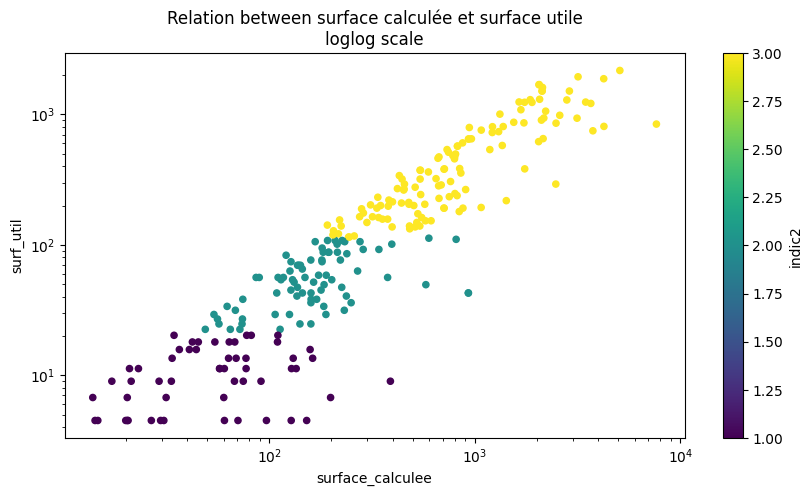

In [11]:
batiments_calcules[batiments_calcules.indic2 > 0].plot.scatter(x="surface_calculee",y="surf_util",c="indic2",colormap='viridis', \
    title='Relation between surface calculée et surface utile\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))

<Axes: title={'center': 'Relation between naive estimation and actual production\nloglog scale'}, xlabel='production', ylabel='calcul_naif_maj'>

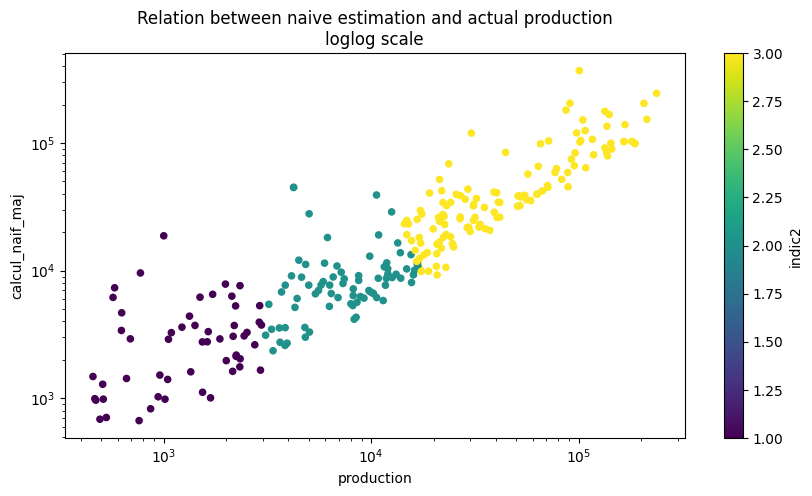

In [12]:
batiments_calcules[batiments_calcules.indic2 > 0].plot.scatter( \
    x="production",y="calcul_naif_maj",c="indic2",colormap='viridis', \
    title='Relation between naive estimation and actual production\nloglog scale', \
    logx=True, logy=True,
    figsize = (10,5))

In [13]:
batiments_calcules.forme.unique()

array(['plat', 'Npans', 'toit2pentes', 'petit_toit'], dtype=object)

In [14]:
batiments_calcules.groupby('forme')

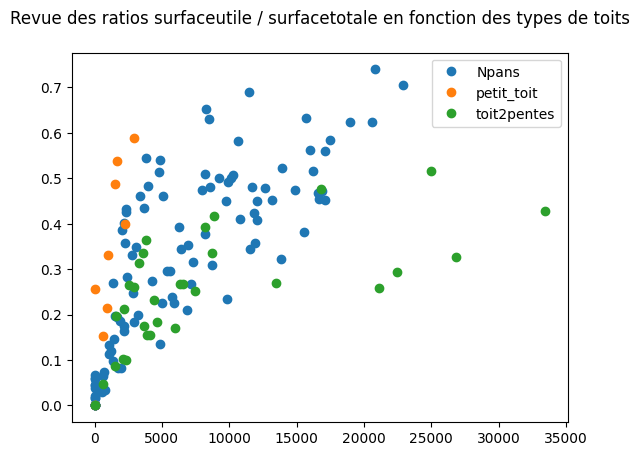

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


groups = batiments_calcules.groupby('forme')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    if name == "plat":
        pass
    else:
        ax.plot(group.production, group.ratio_surface, marker='o', linestyle='', label=name)
ax.legend()
plt.title("Revue des ratios surfaceutile / surfacetotale en fonction des types de toits\n")
plt.show()

# Essayons de prédire les surfaces utiles

In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

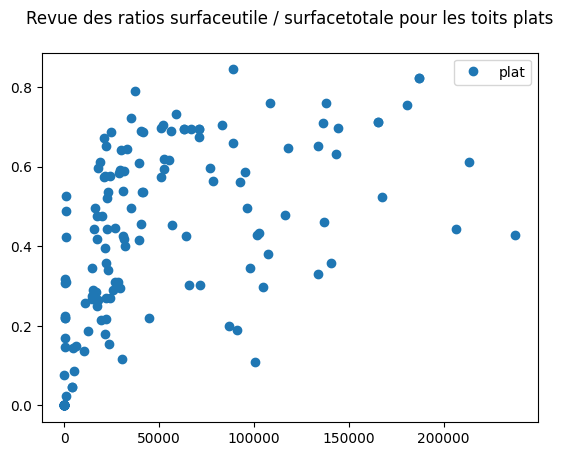

In [62]:
groups = batiments_calcules.groupby('forme')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    if name == "plat":
        ax.plot(group.production, group.ratio_surface, marker='o', linestyle='', label=name)
ax.legend()
plt.title("Revue des ratios surfaceutile / surfacetotale pour les toits plats\n")
plt.show()

In [120]:
batiments_calcules["sqrt_surf"] = batiments_calcules["surface_calculee"].apply(lambda x: np.sqrt(x))
batiments_calcules["ln_surf"] = batiments_calcules["surface_calculee"].apply(lambda x: np.log(x))
data_a_modeler = batiments_calcules[batiments_calcules.forme == "plat"][["surface_calculee","sqrt_surf","ln_surf","surf_util"]]
X = data_a_modeler.iloc[:, :-1].values
y = data_a_modeler.iloc[:, -1].values
data_a_modeler

,surface_calculee,sqrt_surf,ln_surf,surf_util
0,3182.864620,56.416882,8.065537,1944.00
1,4253.467615,65.218614,8.355490,810.00
3,3146.850632,56.096797,8.054157,936.00
5,712.179361,26.686689,6.568330,382.50
6,2592.758766,50.919139,7.860478,985.50
...,...,...,...,...
337,440.248340,20.982096,6.087339,209.25
338,1326.149684,36.416338,7.190035,1005.75
339,820.887091,28.651127,6.710386,238.50
355,782.855874,27.979562,6.662949,483.75


In [121]:
import statsmodels.api as sm
ols = sm.OLS(y, X)
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.844
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              284.1
Date:                Sun, 16 Feb 2025   Prob (F-statistic):                    3.34e-63
Time:                        17:40:02   Log-Likelihood:                         -1109.9
No. Observations:                 160   AIC:                                      2226.
Df Residuals:                     157   BIC:                                      2235.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2227      0.078     -2.849      0.005      -0.377      -0.068
x2            50.0955      7.350      6.815      0.000      35.577      64.614
x3          -114.3733     21.598     -5.295      0.000    -157.034     -71.712
==============================================================================
Omnibus:                       11.461   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               28.566
Skew:                           0.090   Prob(JB):                     6.27e-07
Kurtosis:                       5.062   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: xlabel='surf_util', ylabel='predicted'>

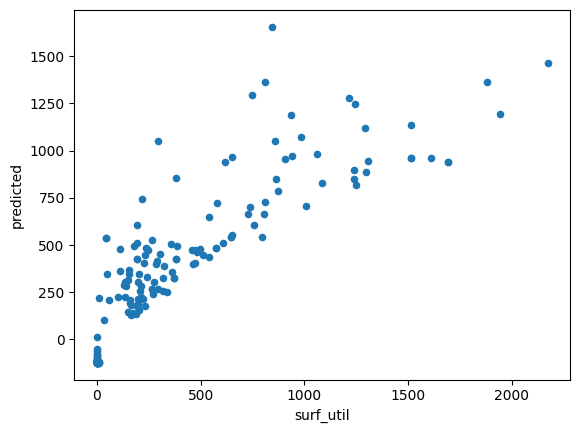

In [122]:
data_a_modeler["predicted"] = ols_result.predict()
data_a_modeler.plot.scatter(x="surf_util",y="predicted")

<Axes: title={'center': 'Surface utile vs surface calculée'}, xlabel='surface_calculee', ylabel='surf_util'>

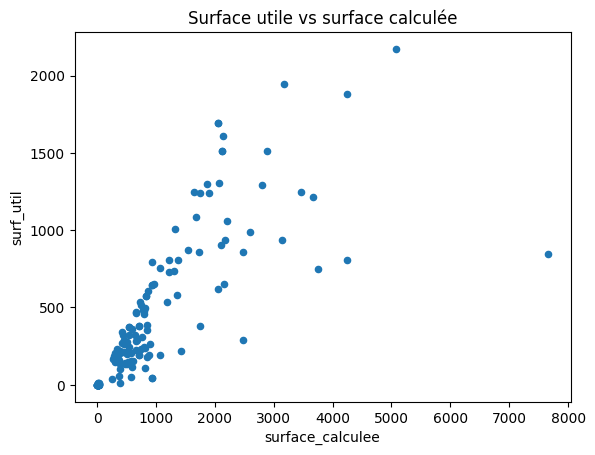

In [125]:
data_a_modeler.plot.scatter(x="surface_calculee",y="surf_util",title="Surface utile vs surface calculée")

# Autre exploration

In [50]:
df = batiments_calcules.merge(batiments_reference,on="cleabs")
df.columns = [col.replace("_x","") for col in list(df.columns)]
df.head()

,surface_calculee,surf_util,production,calcul_naif,moyenne2,indic2,forme,gisement,eq_pano,eq_surf,...,ratio_surface,nature__bat,usage_1,usage_2,nombre_d_etages,materiaux_des_murs,materiaux_de_la_toiture,hauteur,geometry_y,surface_calculee_y
0,3182.864620,1944.00,213541.062838,3.501151e+06,1205.511696,3,plat,important,plus de 50 panneaux,plus de 115 m2,...,0.610771,Indifférenciée,Commercial et services,None,NaN,None,None,14.3,"MULTIPOLYGON Z (((2.36719 48.93004 40.8, 2.366...",3182.864620
1,4253.467615,810.00,90874.379954,4.678814e+06,1231.240041,3,plat,important,plus de 50 panneaux,plus de 115 m2,...,0.190433,Indifférenciée,Commercial et services,None,NaN,None,None,11.3,"MULTIPOLYGON Z (((2.36013 48.91242 45.8, 2.360...",4253.467615
2,128.561045,2.25,0.000000,1.414171e+05,NaN,-1,Npans,Non favorable,Non favorable,Non favorable,...,0.017501,Indifférenciée,Commercial et services,Résidentiel,5.0,00,00,4.5,"MULTIPOLYGON Z (((2.35275 48.94371 33.4, 2.352...",128.561045
3,3146.850632,936.00,104887.667195,3.461536e+06,1229.801070,3,plat,important,plus de 50 panneaux,plus de 115 m2,...,0.297440,Indifférenciée,Commercial et services,None,NaN,None,None,17.7,"MULTIPOLYGON Z (((2.34956 48.93933 47.9, 2.349...",3146.850631
4,552.109173,162.00,22486.547854,6.073201e+05,1134.034730,3,toit2pentes,important,plus de 50 panneaux,plus de 115 m2,...,0.293420,Indifférenciée,Commercial et services,None,NaN,None,None,6.5,"MULTIPOLYGON Z (((2.38134 48.93547 33.1, 2.381...",552.109174


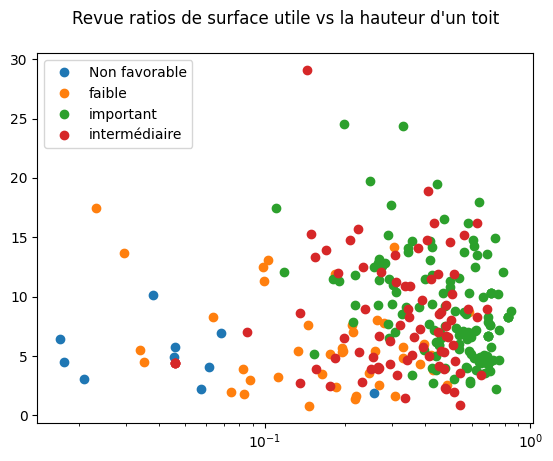

In [57]:

groups = df.groupby('gisement')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    if name == "plat":
        pass
    else:
        ax.plot(group.ratio_surface, group.hauteur, marker='o', linestyle='', label=name)
ax.set_xscale('log')
ax.legend()
plt.title("Revue ratios de surface utile vs la hauteur d'un toit\n")
plt.show()

# Ajout de la layer potentiel solaire 

PV_Sol_Polygon.gpkg
* Couche: PV_Sol avec 2016422 éléments.
* Couche: layer_styles avec 1 éléments.

In [17]:
mask_stdenis = stdenis.to_crs(2154)

In [18]:
src = DATA_FOLDER / "ENR_1-0_POT-SOL-SOL_GPKG_LAMB93_FXX_2024-04-01/1_DONNEES_LIVRAISON/PV_Sol_Polygon.gpkg"
layers = fiona.listlayers(src)


In [19]:
enrpot = gpd.read_file(src, layer="PV_Sol", mask = mask_stdenis)
enrpot

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'PV_Sol_Polygon.gpkg': 'PV_Sol' (default), 'layer_styl

,objectid,classe,region,geometry
0,1356053,Réseaux routiers et ferroviaires,Île-de-France,"MULTIPOLYGON (((656436.5 6894531, 656438.799 6..."
1,871998,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((654025.136 6867560.505, 654013..."
2,872121,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((652984.728 6867576.176, 652985..."
3,871992,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((653831.991 6867843.593, 653815..."
4,872122,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((653407.343 6867644.803, 653399..."
...,...,...,...,...
206,872075,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((655113.813 6871546.614, 655116..."
207,888472,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((653591.409 6871971.731, 653583..."
208,872037,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((655070.762 6870563.567, 655066..."
209,872038,Inadapté sauf exception,Île-de-France,"MULTIPOLYGON (((654812.921 6870547.068, 654722..."


# Representing the area for StDenis

<Axes: >

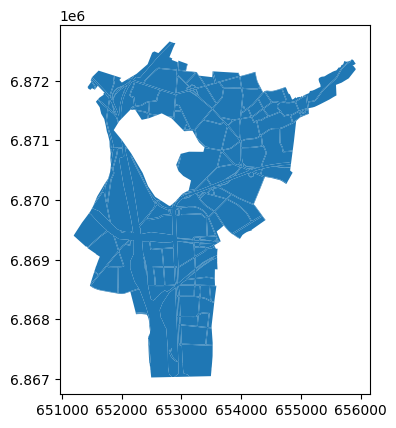

In [20]:
enrpot.clip(mask_stdenis).plot()